In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert cylindrical to rectangular
x, y, z = (samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vx, vy, vz = (samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5])
samples_qdf = np.stack((x, y, z, vx, vy, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (x)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (y)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vx)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vy)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))
print(np.std(samples_qdf[:,0]), np.std(samples_qdf[:,1]), np.std(samples_qdf[:,2]), np.std(samples_qdf[:,3]), np.std(samples_qdf[:,4]), np.std(samples_qdf[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1699708
min/max/mean (x) -8.799609236140716 -7.8009001178134145 -8.28941027928639
min/max/mean (y) -0.49953870661065697 0.4995682614628541 0.002482278453398873
min/max/mean (z) -0.47224099228924643 0.5251864323212104 0.020554162071444157
min/max/mean (vx) -229.1334501573963 225.79860587229317 -0.06492600565603411
min/max/mean (vy) -300.7405372012659 -18.65795773589432 -200.86464268462737
min/max/mean (vz) -78.63184750506196 79.49529776718326 -0.001518106057358567
0.19571259103563388 0.20481341620514137 0.16310598222016867 44.80821430082615 32.31085942773585 18.98694921618029


In [2]:
#Importing the required modules
import numpy as np
from sklearn.neighbors import KernelDensity

#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-07-15 - Updated - Ayush Pandhi
    """
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Multivariate Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = 5 * np.nanstd(inputs) * N ** (-1/10.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-07-15 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_phi = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vR = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vT = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Variable R at Scotts bw


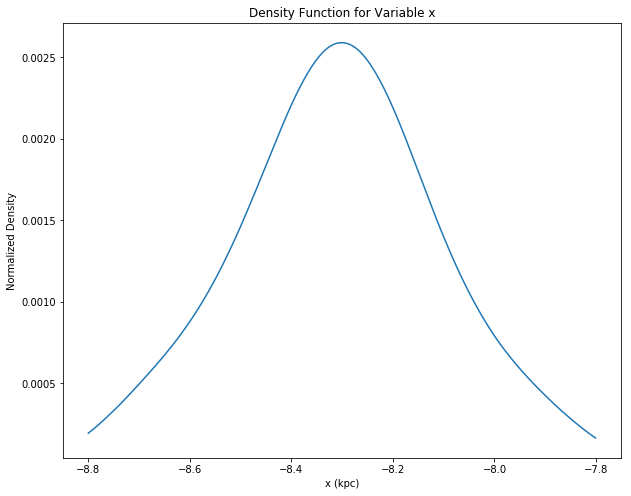

In [5]:
#Variable R plot
print('Variable R at Scotts bw')
plt.figure(figsize = (10, 8))
Rplot_epanechnikov = kde_qdf_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)
plt.xlabel('x (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable x')
plt.savefig('zscore_cart_variable_x')
plt.show()

Variable phi at Scotts bw


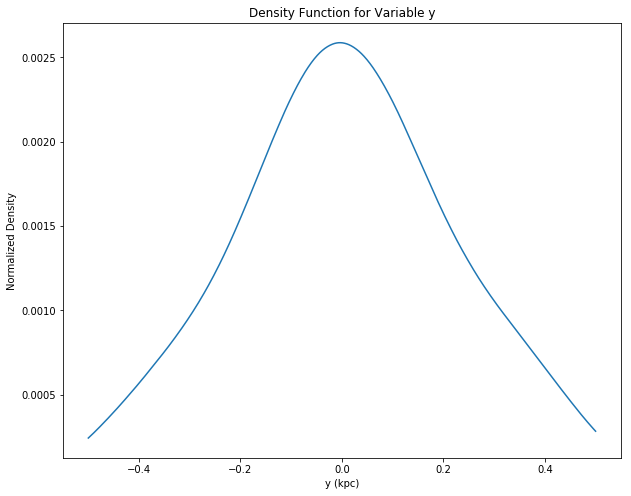

In [6]:
#Variable phi plot
print('Variable phi at Scotts bw')
plt.figure(figsize = (10, 8))
phiplot_epanechnikov = kde_qdf_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)
plt.xlabel('y (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable y')
plt.savefig('zscore_cart_variable_y')
plt.show()

Variable z at Scotts bw


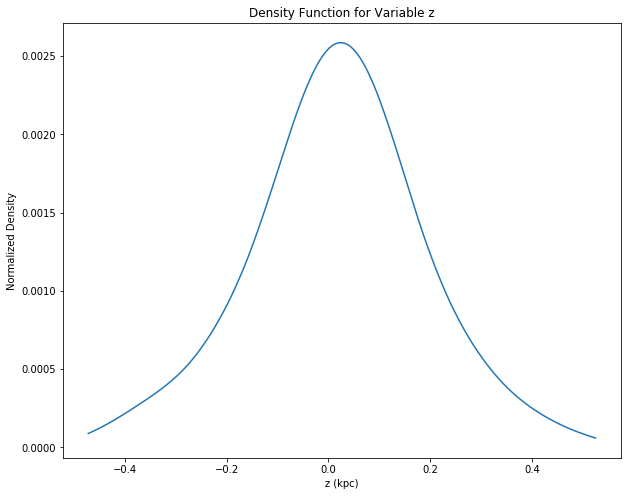

In [7]:
#Variable z plot
print('Variable z at Scotts bw')
plt.figure(figsize = (10, 8))
zplot_epanechnikov = kde_qdf_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable z')
plt.savefig('zscore_cart_variable_z')
plt.show()

Variable vR at Scotts bw


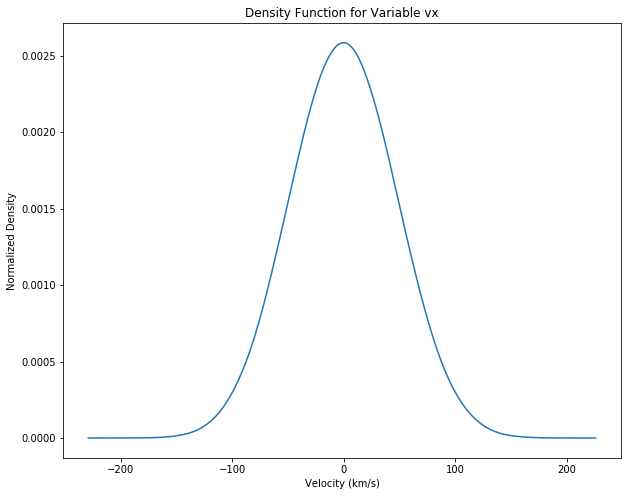

In [8]:
#Variable vR plot
print('Variable vR at Scotts bw')
plt.figure(figsize = (10, 8))
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vx')
plt.savefig('zscore_cart_variable_vx')
plt.show()

Variable vT at Scotts bw


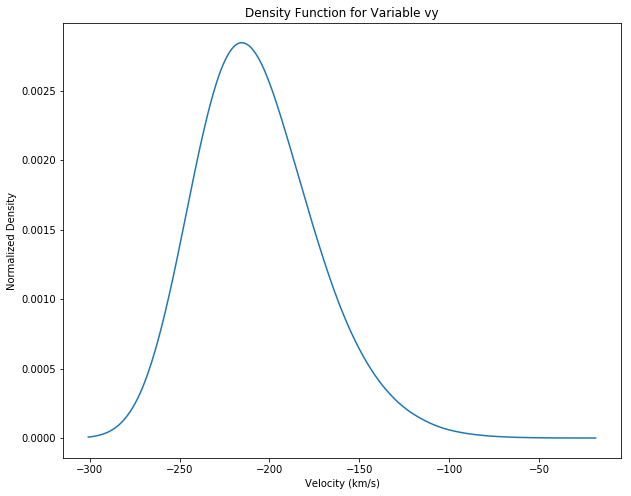

In [9]:
#Variable vT plot
print('Variable vT at Scotts bw')
plt.figure(figsize = (10, 8))
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vy')
plt.savefig('zscore_cart_variable_vy')
plt.show()

Variable vz at Scotts bw


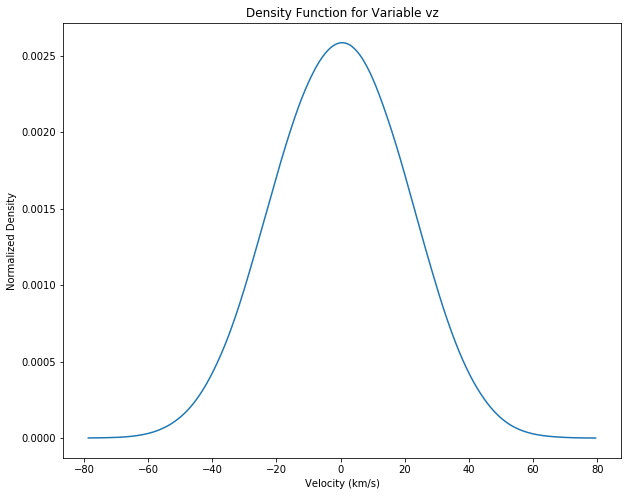

In [10]:
#Variable vz plot
print('Variable vz at Scotts bw')
plt.figure(figsize = (10, 8))
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vz')
plt.savefig('zscore_cart_variable_vz')
plt.show()

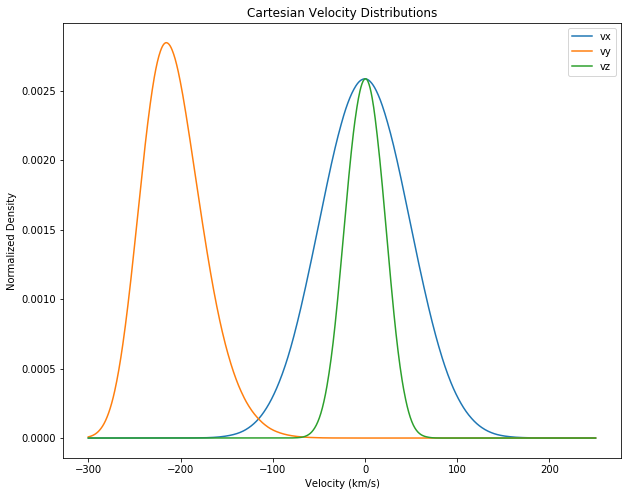

In [11]:
#For variable vR
vR_points = np.linspace(-300, 250, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-300, 250, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-300, 250, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities
plt.figure(figsize = (10, 8))

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vx')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vy')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Cartesian Velocity Distributions')
plt.legend()
plt.savefig('zscore_cart_velocity_distribution')
plt.show()